# One-Dimensional Infinite Square Well

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.animation

In [3]:
from IPython.display import HTML

In [4]:
import scipy.fftpack

The periodic evolution of a normalized initial state $\Psi(x,0)$ in a well of size $a$ can be expanded in terms of energy eigenstates as:
$$
\Psi(x, t) = \sqrt{\frac{2}{a}}\, \sum_{n=1}^\infty c_n \sin(k_n x) \exp(-i\omega_n t)
$$
with
$$
k_n = n \frac{\pi}{a} \quad , \quad
\omega_n = n^2 \frac{2\pi}{T} \quad, \quad
c_n = \sqrt{\frac{2}{a}}\,\int_0^a \sin(k_n x)\,\Psi(x, 0)\,dx
\; ,
$$
and period
$$
T = \frac{\pi\hbar}{4 m a^2} \; .
$$

Note that this is almost the same as the [evolution of a massless string](http://hyperphysics.phy-astr.gsu.edu/hbase/Waves/string.html) under constant tension $\tau$, where now $\text{Re}\Psi(x,t)$ is the transverse displacement, except that
$$
\omega_n = n \frac{2\pi}{T} \; ,
$$
since all modes $n$ propagate at the same speed,
$$
v = \frac{\omega_n}{k_n} = \frac{2 a}{T} = \sqrt{\frac{\tau}{\rho}} \; .
$$
Another difference is that the fundamental period $T$ of a classical string,
$$
T = \frac{2a}{v} = \sqrt{\frac{4 \rho a^2}{\tau}} \; ,
$$
scales with $a$ while the quantum system has a period that scales with $a^{-2}$.

The function below solves for the complex-valued $\Psi(x,t)$ given a function to evalute the initial (real) $\Psi(x,0)$, for times $t$ equally spaced on $[0, T)$.  The scale $a=1$ is fixed.

In [5]:
def calculate(initial, nx=100, nt=10, quantum=True):
    """Solve the 1D classical or quantum wave equation with fixed endpoints.
    
    Parameters
    ----------
    initial : callable
        Function called with an array of x values in [0, 1) that should return an
        array of (un-normalized) psi(x, 0) values.
    nx : int
        Number of subdivisions of the interval [0, 1] to use, which fixes the
        allowed mode numbers to n = 1, 2, ..., nx - 2.
    nt : int
        Number of equally spaced times to subdivide [0, T) into.
    quantum : bool
        Use omega proportional to n ** 2 (quantum) or n (classical), where n is
        the mode number.
        
    Returns
    -------
    array
        Complex array of shape (nt, nx) with calculated psi(x, t).
    """
    # Tabulate the initial state.
    x = np.linspace(0., 1., nx)
    psi0 = initial(x)
    if not np.allclose(psi0[[0, -1]], 0):
        raise ValueError('Initial state does not satisfy the boundary conditions.')
        
    # Normalize the initial state.
    normsq = np.trapz(np.abs(psi0) ** 2, x)
    psi0 /= np.sqrt(normsq)

    # Calculate initial coefficients.
    n = np.arange(1, nx - 1)
    c0 = scipy.fftpack.dst(psi0[1:-1], type=1)
    
    # Evolve each coefficient through one period.
    tfrac = np.linspace(0., 1., nt, endpoint=False).reshape(-1, 1)
    omegaT = 2 * np.pi * (n ** 2 if quantum else n)
    phi = np.exp(-1j * omegaT * tfrac)
    c = c0 * phi

    # Reconstruct wavefunctions at each time step.
    psi = np.zeros((nt, nx), np.complex)
    psi[:, 1:-1] = scipy.fftpack.idst(c, type=1, axis=1) / (2. * (nx - 1))
    return psi

Define some initial states:
 - A superposition of low-order standing waves.
 - A narrow pulse.
 - A plucked string.

In [6]:
def harmonic(*coefs):
    n = np.arange(1, len(coefs) + 1)
    def initial(x):
        return (coefs * np.sin(np.pi * n * x.reshape(-1, 1))).sum(axis=1)
    return initial

In [7]:
def pulse(x0=0.5, dx=0.1):
    def initial(x):
        y = np.zeros_like(x)
        sel = np.abs(x - x0) < dx
        y[sel] = np.cos(0.5 * np.pi * (x[sel] - x0) / dx)
        return y
    return initial

In [8]:
def pluck(x0=0.5):
    def initial(x):
        y = np.empty_like(x)
        sel = x < x0
        y[sel] = x[sel] / x0
        y[~sel] = (1 - x[~sel]) / (1 - x0)
        return y
    return initial

Animate some examples, using ffmpeg for mp4 encoding:

In [9]:
def animate_examples(nx=100, nt=300, save=None):
    
    models = [ harmonic(1, 1), pulse(0.4, 0.2), pluck(0.4) ]
    classical = [ calculate(model, nx, nt, quantum=False) for model in models ]
    quantum = [ calculate(model, nx, nt, quantum=True) for model in models ]
    
    figure, ax = plt.subplots(len(models), 3, sharex=True, figsize=(12, 9))
    plt.subplots_adjust(0.,0.,0.999,0.999,0.01,0.02)
    ylim = np.array([
        1.05 * np.max(np.abs(np.real(quantum)), axis=(1,2)),
        1.05 * np.max(np.absolute(quantum) ** 2, axis=(1,2))
    ])
    artists = []
    x = np.linspace(0, 1, nx)
    y = np.zeros_like(x)
    for im in range(len(models)):
        artists += ax[im,0].plot(x, y, 'r', lw=2)
        artists += ax[im,1].plot(x, y, 'r', lw=2)
        artists += ax[im,1].plot(x, y, 'b:', lw=2)
        artists += ax[im,2].plot(x, y, 'k', lw=2)
    for im in range(len(models)):
        artists += ax[im,0].plot(x, np.real(classical[im][0]), alpha=0.25, lw=5, c='gray')
        artists += ax[im,1].plot(x, np.real(quantum[im][0]), alpha=0.25, lw=5, c='gray')
        ax[im,0].set_ylim(-ylim[0,im], +ylim[0,im])
        ax[im,1].set_ylim(-ylim[0,im], +ylim[0,im])
        ax[im,2].set_ylim(0, ylim[1,im])
        for col in range(3):
            ax[im,col].set_xlim(0, 1)
            ax[im,col].set_xticks([])
            ax[im,col].set_yticks([])
            
    def init():
        return artists
    
    def update(it):
        for im in range(len(models)):
            artists[4 * im + 0].set_ydata(np.real(classical[im][it]))
            artists[4 * im + 1].set_ydata(np.real(quantum[im][it]))
            artists[4 * im + 2].set_ydata(np.imag(quantum[im][it]))
            artists[4 * im + 3].set_ydata(np.absolute(quantum[im][it]) ** 2)
        return artists
        
    animation = matplotlib.animation.FuncAnimation(
        figure, update, init_func=init, frames=nt, repeat=True, blit=True)
    if save:
        writer = matplotlib.animation.writers['ffmpeg'](bitrate=1200, fps=30)
        animation.save(save, writer=writer)
        
    return animation

The following command encodes and saves an mp4 file, but also displays a single frame inline. The rows correspond to the different initial states:
 - TOP: The sum of the lowest-order standing waves (with equal coefficients).
 - MIDDLE: A "half cosine" pulse.
 - BOTTOM: A plucked string.
 
The columns show:
 - LEFT: real part of $\Psi(x,t)$ for a classical wave ($\omega_n \propto n$) on a string fixed at both ends.
 - CENTER: real (red) and imaginary (dotted blue) parts of $\Psi(x,t)$ for a quantum wave ($\omega_n \propto n^2$) fixed at both ends.
 - RIGHT: probability density $|\Psi(x,t)|^2$ for the the quantum wave.
 
Note how replacing $\omega_n \propto n$ with $\omega_n \propto n^2$ changes the evolution significantly and adds much higher frequency components.

If the classical plucked string looks unphysical, see this [high-speed footage](https://youtu.be/Qr_rxqwc1jE).

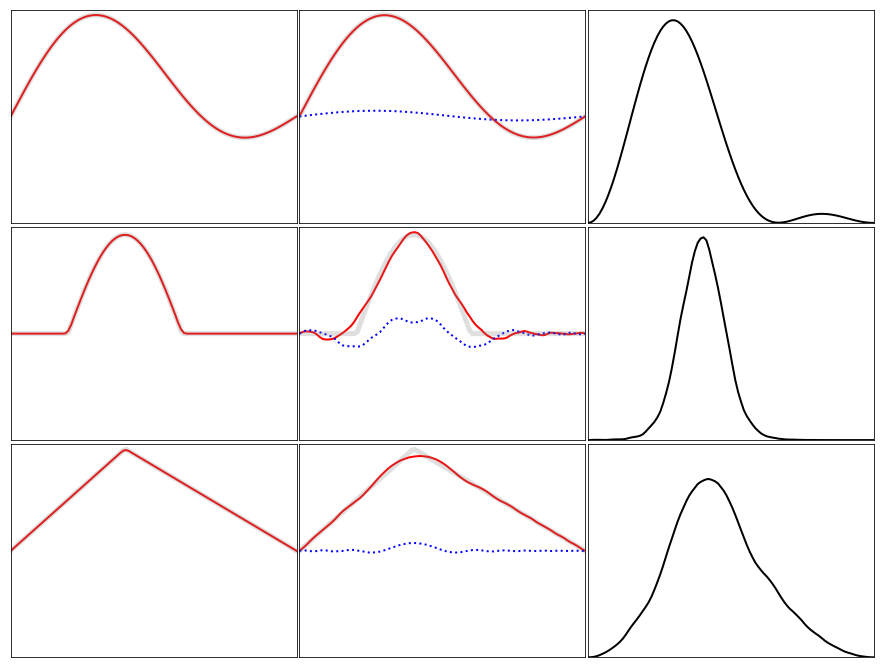

In [10]:
animate_examples(save='isw.mp4');

Uncomment and run the line below to display the animation inline:

In [11]:
#HTML(animate_examples().to_html5_video())